# Reproducible Figure Instructions – MSU Curriculum Maps

This notebook provides complete, step-by-step instructions for generating one of the figures used in the **MSU Curriculum Maps** project:  
a directed curriculum/prerequisite graph built from cleaned course data.

- **Repository:** [JackRobertson77/MSU_Curriculum_Maps](https://github.com/JackRobertson77/MSU_Curriculum_Maps)

---

## 0. Prerequisites & Installation

Before running this notebook:

1. **Install dependencies** following the steps in [`install.md`](../install.md).  
2. **Verify your environment** by running [`INSTALL_AND_TEST.ipynb`](INSTALL_AND_TEST.ipynb) — this confirms required libraries (`pandas`, `networkx`, `matplotlib`, etc.) are installed correctly.  
3. **Prepare the data:**  
   - Download `curriculum_clean.csv` from your project data source.
   - You do NOT need to run `clean_data.py` for this milestone if `curriculum_clean.csv` is already present.  
   - Place it in the **same folder** as this notebook (or in the repo root if you run from there).  
4. Launch Jupyter Lab and open this notebook.

Once these steps are complete, proceed to **Section 1: Environment Setup & Imports.**


## 1. Environment Setup & Imports

In [27]:
import os
import re
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

os.makedirs("figures", exist_ok=True)


## 2. Load and Prepare Dataset
Make sure the cleaned dataset `curriculum_clean.csv` is in the project root. If missing, run `python clean_data.py`.

In [1]:
import os
import pandas as pd

data_path = 'curriculum_clean.csv'

if not os.path.exists(data_path):
    raise FileNotFoundError(f'{data_path} not found. Run clean_data.py or rename your file to curriculum_clean.csv.')

data = pd.read_csv(data_path)
print("Loaded:", data_path, "with shape:", data.shape)
data.head()

Loaded: curriculum_clean.csv with shape: (2661, 14)


,Major Code,Major Title,Plan Title,Course ID,Course Name,Year Level,Term Season,Fifth Year,Credits,Credits Minimum,Prerequisites,Prerequisite Term,Has Prerequisites,Is Prerequisite For
0,3576,"Chemistry, BA",Chemistry - Plan B,CEM 161,Chemistry Laboratory I,Freshman,Spring,No,120,1,NaN,1,False,6
1,3576,Chemistry,Chemistry BA - Plan A,CEM 161,Chemistry Laboratory I,Freshman,Fall,No,120,1,NaN,1,False,6
2,3576,"Chemistry, BA",Chemistry - Plan B,MTH 103,College Algebra,Freshman,Fall,No,120,3,NaN,1,False,23
3,3576,Chemistry,Chemistry BA - Plan A,MTH 116,College Algebra and Trigonometry,Freshman,Fall,No,120,5,NaN,1,False,4
4,3576,Chemistry,Chemistry BA - Plan A,CEM 162,Chemistry Laboratory II,Freshman,Spring,No,120,1,(CEM 161 AND CEM 186H),2,True,5


## 3. Data Cleaning & Prerequisite Extraction

In [29]:
if "Prerequisites" not in data.columns:
    raise KeyError("The column 'Prerequisites' was not found in the CSV.")

# make the column string-like and normalize "NaN"
data["Prerequisites"] = (
    data["Prerequisites"]
    .astype(str)
    .str.strip()
    .replace("NaN", np.nan)
)

def extract_courses(prereq):
    """Return a list of unique course codes like 'CEM 141', 'MTH 132' from a prereq string."""
    if pd.isna(prereq):
        return []
    # match e.g. 'CEM 141', 'MTH132', 'STT 224'
    courses = re.findall(r"[A-Z]{2,4}\s*\d{3}", prereq)
    # keep order, drop dupes
    return list(dict.fromkeys(courses))

data["Cleaned_Prereqs"] = data["Prerequisites"].apply(extract_courses)

data[["Course ID", "Prerequisites", "Cleaned_Prereqs"]].head(10)


,Course ID,Prerequisites,Cleaned_Prereqs
0,CEM 161,nan,[]
1,CEM 161,nan,[]
2,MTH 103,nan,[]
3,MTH 116,nan,[]
4,CEM 162,(CEM 161 AND CEM 186H),"[CEM 161, CEM 186]"
5,MTH 114,MTH 103 OR MTH 103B,[MTH 103]
6,MTH 132,(MTH 103 AND MTH 103B),[MTH 103]
7,CEM 141,(CEM 151 AND MTH 103B),"[CEM 151, MTH 103]"
8,CEM 141,(CEM 151 AND MTH 103B),"[CEM 151, MTH 103]"
9,CEM 142,(CEM 141 AND CEM 152),"[CEM 141, CEM 152]"


## 4. Build Curriculum Graph (Nodes & Edges)

In [30]:
G = nx.DiGraph()

# 1. add all courses as nodes with attributes
for _, row in data.iterrows():
    course_id = row["Course ID"]
    G.add_node(
        course_id,
        name=row.get("Course Name", ""),
        major=row.get("Major Code", ""),
        major_title=row.get("Major Title", ""),
        year=row.get("Year Level", ""),
        term=row.get("Term Season", ""),
        credits=row.get("Credits", ""),
        has_prereq=row.get("Has Prerequisites", False),
    )

# 2. add edges prereq -> course
for _, row in data.iterrows():
    course = row["Course ID"]
    prereqs = row["Cleaned_Prereqs"]
    for p in prereqs:
        # add edge from prereq to current course
        G.add_edge(p, course)

print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")
print("Sample edges:", list(G.edges())[:10])



Total nodes: 222
Total edges: 239
Sample edges: [('CEM 161', 'CEM 162'), ('CEM 161', 'CEM 255'), ('MTH 103', 'MTH 114'), ('MTH 103', 'MTH 132'), ('MTH 103', 'CEM 141'), ('MTH 103', 'MTH 124'), ('MTH 103', 'STT 201'), ('MTH 103', 'STT 200'), ('MTH 103', 'STT 224'), ('MTH 116', 'CEM 151')]


## 5. Visualize and Export Curriculum Graph

/var/folders/90/14yqyrnj6_5dfglmq5jz_s2w0000gn/T/ipykernel_38065/1863959053.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


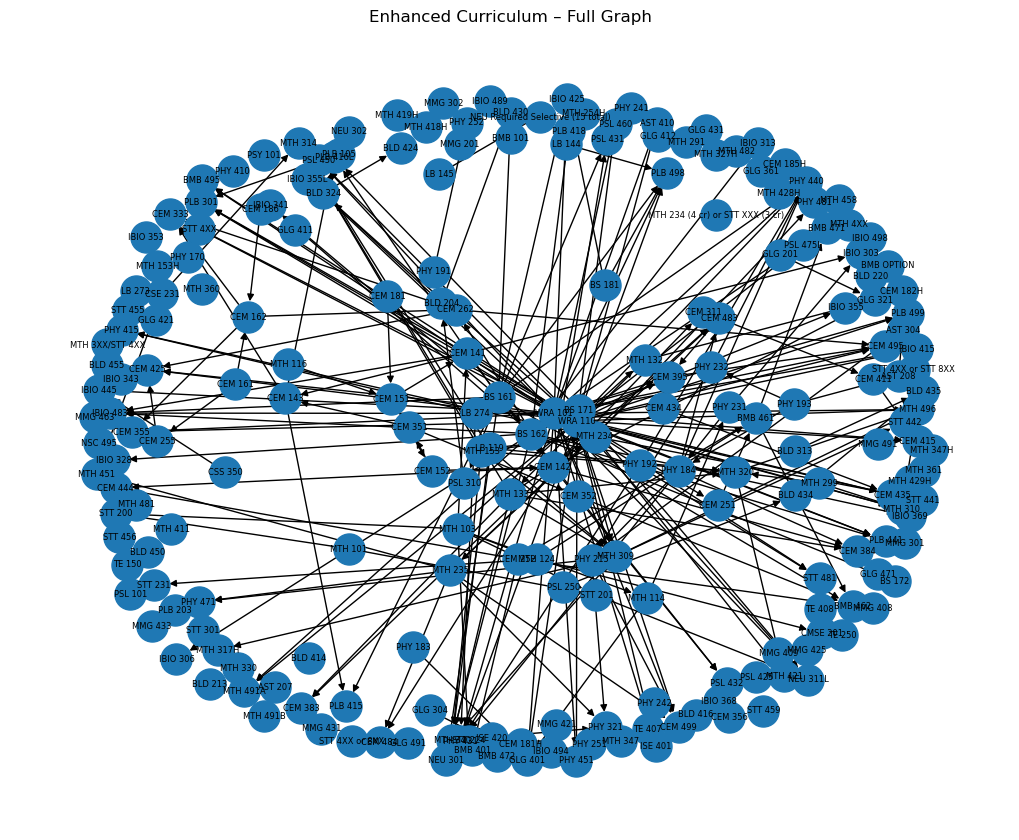

In [31]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.3, seed=42)
nx.draw(G, pos, with_labels=True, node_size=500, font_size=6)
plt.title("Enhanced Curriculum – Full Graph")
plt.tight_layout()

os.makedirs("figures", exist_ok=True)
plt.savefig("figures/curriculum-graph-full.png", dpi=300)

plt.show()
print("Saved to: figures/curriculum-graph-full.png")


## 6. Generate Major-Specific Subgraph

/var/folders/90/14yqyrnj6_5dfglmq5jz_s2w0000gn/T/ipykernel_38065/2756880424.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


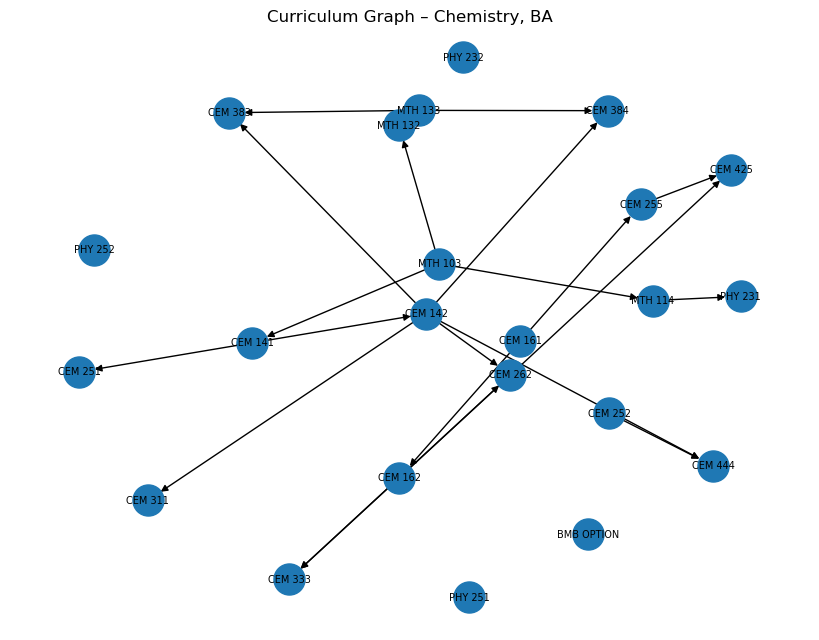

saved to: figures/curriculum-Chemistry_BA.png


<Figure size 640x480 with 0 Axes>

In [32]:
major = "Chemistry, BA"
major_nodes = data[data["Major Title"] == major]["Course ID"]

sub = G.subgraph(major_nodes).copy()

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(sub, seed=42)
nx.draw(sub, pos, with_labels=True, node_size=500, font_size=7)
plt.title(f"Curriculum Graph – {major}")
plt.tight_layout()
plt.show()

# export
outpath = f"figures/curriculum-{major.replace(',', '').replace(' ', '_')}.png"
plt.gcf().savefig(outpath, dpi=300)
print("saved to:", outpath)